# Cart Pole
通过在小车上向左和向右施加力来平衡杆

In [1]:
from IPython.display import display, HTML

# Create an HTML img tag to display the image with a set width and height
image_html = '<img src="../image/cart_pole.png" width="400" height="300" alt="Mountain Car"/>'

# Use IPython.display to show the image
display(HTML(image_html))

In [1]:
import gym
import math
import numpy as np
import pandas as pd

# 超过十位数可看作无穷infinite
def format_value(x):
    threshold = 1e+10
    if abs(x) > threshold:
        return "inf"
    else:
        return f"{x:.2f}"


env = gym.make("CartPole-v1", render_mode="rgb_array")

# 有两种离散动作: 小车向左, 向右
print(f"动作: {env.action_space}")
# 观测数据有四项
print(f"小车位置, 小车速度, 杆角度, 杆角速度的最大值, : {[format_value(x) for x in env.observation_space.high]}")
print(f"小车位置, 小车速度, 杆角度, 杆角速度的最小值: {[format_value(x) for x in env.observation_space.low]}")
UPPER_BOUNDS = [env.observation_space.high[0], 0.5, env.observation_space.high[2], math.radians(50) / 1.]
LOWER_BOUNDS = [env.observation_space.low[0], -0.5, env.observation_space.low[2], -math.radians(50) / 1.]
print(f"修正最大值{UPPER_BOUNDS}")
print(f"修正最小值{LOWER_BOUNDS}")

BUCKETS = (1, 1, 12, 12)
print(f"离散观测结果集合维度为{BUCKETS}")

# 学习率 α
LEARNING_RATE = 0.1
# 最小EPSILON
EPSILON = 0.1
# EPSILON和学习率衰减
DECAY = 25
# 衰退因子 γ
GAMMA = 0.98
# 训练周期
EPISODES = 1000

动作: Discrete(2)
小车位置, 小车速度, 杆角度, 杆角速度的最大值, : ['4.80', 'inf', '0.42', 'inf']
小车位置, 小车速度, 杆角度, 杆角速度的最小值: ['-4.80', 'inf', '-0.42', 'inf']
修正最大值[4.8, 0.5, 0.41887903, 0.8726646259971648]
修正最小值[-4.8, -0.5, -0.41887903, -0.8726646259971648]
离散观测结果集合维度为(1, 1, 12, 12)


/home/yuanhao/workspace/ai-manufacturing-demo/venv/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


随机位置[-0.00576648  0.18887828 -0.04312685 -0.31988624]
随机状态(0, 0, 5, 3)
table维度(1, 1, 12, 12, 2)


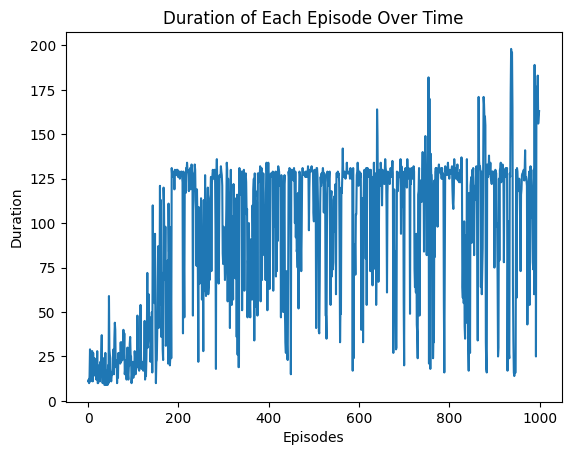

In [2]:
import matplotlib.pyplot as plt

def get_discrete_state(obs):
    discrete_state = []
    for i in range(len(obs)):
        # Scale the continuous state to the range [0, 1].
        scaled_obs = (obs[i] + abs(LOWER_BOUNDS[i])) / (UPPER_BOUNDS[i] - LOWER_BOUNDS[i])
        # Scale the observation according to the number of buckets.
        discrete_obs = int(round((BUCKETS[i] - 1) * scaled_obs))
        # Ensure the discrete observation is within the valid bucket range.
        discrete_obs = max(0, min(BUCKETS[i] - 1, discrete_obs))
        discrete_state.append(discrete_obs)
    return tuple(discrete_state)

def choose_action(q_actions, epsilon):
    if (np.random.random() < epsilon):
        return env.action_space.sample() 
    else:
        return np.argmax(q_actions)

def update_q_table(q_table, reward, learning_rate, state, action, new_state, new_action):
    q_table[state][action] += learning_rate * (reward + GAMMA * (q_table[new_state][new_action]) - q_table[state][action])

def get_epsilon(ep):
    return max(EPSILON, min(1., 1. - math.log10((ep + 1) / DECAY)))

def get_learning_rate(ep):
    return max(LEARNING_RATE, min(1., 1. - math.log10((ep + 1) / DECAY)))

env.reset()
observation, reward, terminated, truncated, info = env.step(env.action_space.sample())
print(f"随机位置{observation}")
discrete_state = get_discrete_state(observation)
print(f"随机状态{discrete_state}")

# 初始化Q表
q_table = np.zeros(BUCKETS + (env.action_space.n,))
print(f"table维度{q_table.shape}")

# 保存"坚持步数"和"回合"的关系
durations = []
for ep in range(EPISODES):
    current_state = get_discrete_state(env.reset(seed=42)[0])
    learning_rate = get_learning_rate(ep)
    epsilon = get_epsilon(ep)
    step_count = 0
    done = False
    while not done:
        step_count = step_count + 1
        current_action = choose_action(q_table[current_state], epsilon)
        obs, reward, done, _, _ = env.step(current_action)
        new_state = get_discrete_state(obs)
        new_action = choose_action(q_table[new_state], epsilon)
        update_q_table(q_table, reward, learning_rate, current_state, current_action, new_state, new_action)
        current_state = new_state
    durations.append(step_count)

# 作图展示"坚持步数"和"回合"的关系, 似乎不太稳定, 很有可能与learning rate, epsilon的衰减策略有关
plt.plot(range(EPISODES), durations)
plt.xlabel('Episodes')
plt.ylabel('Duration')
plt.title('Duration of Each Episode Over Time')
plt.show()

In [4]:
from gym.wrappers.monitoring.video_recorder import VideoRecorder

video = VideoRecorder(env, "../video/cart_pole.mp4")

current_state = get_discrete_state(env.reset(seed=42)[0])
while not done:
    env.render()
    video.capture_frame()
    current_action = choose_action(q_table[current_state], epsilon)
    obs, reward, done, _, _ = env.step(current_action)
    new_state = get_discrete_state(obs)
    new_action = choose_action(q_table[new_state], epsilon)
    update_q_table(q_table, reward, learning_rate, current_state, current_action, new_state, new_action)
    current_state = new_state
video.close()
env.close()